In [14]:
import pandas as pd
import numpy as np

import yfinance as yf

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import t
from scipy import stats
from scipy.stats import normaltest
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import tree 
from sklearn import ensemble 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics 

import optuna

In [15]:
# Настройка цветовой гаммы 
sns.set_theme(style = "darkgrid")
clrmap = ["#e74c3c","#2ecc71","#9b59b6", "#95a5a6", "#34495e","#3498db"]
sns.set_palette(clrmap)

# 1

In [16]:
# Загрузка котрировок используя yfinance
tickers_list = ['AAPL','GOOG','META']

data = pd.DataFrame(columns=tickers_list)

for ticker in tickers_list:
    data[ticker] = yf.download(ticker,'2012-08-30','2022-08-30')['Close']

data.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,AAPL,GOOG,META
Date,,,
2012-08-29,24.052500,17.136021,19.100000
2012-08-30,23.709642,16.978361,19.090000
2012-08-31,23.758572,17.063293,18.059999
2012-09-04,24.106071,16.962421,17.730000
2012-09-05,23.936787,16.954451,18.580000


# 2

In [17]:
#создаем список daily
columns = list(data.columns)
daily_returns = []
for i in range (0, len(columns)):
    daily_returns.append(columns[i]+'_daily_return')

In [18]:
#добавляем столбцы daily returns в dataframe
for i in range (0, len(daily_returns)):
    data[daily_returns[i]] = data[columns[i]].pct_change(1)
    
data = data.fillna(0)
data.head() 

,AAPL,GOOG,META,AAPL_daily_return,GOOG_daily_return,META_daily_return
Date,,,,,,
2012-08-29,24.052500,17.136021,19.100000,0.000000,0.000000,0.000000
2012-08-30,23.709642,16.978361,19.090000,-0.014255,-0.009200,-0.000524
2012-08-31,23.758572,17.063293,18.059999,0.002064,0.005002,-0.053955
2012-09-04,24.106071,16.962421,17.730000,0.014626,-0.005912,-0.018272
2012-09-05,23.936787,16.954451,18.580000,-0.007022,-0.000470,0.047941


In [19]:
#первая версия получения daily returns
for col in daily_returns:
    data[col] = ''
    for i in range (1, data.shape[0]):
        data[col][0] = 0
        data[col][i] = data[col.replace('_daily_return', '')].diff().values[i] / data[col.replace('_daily_return', '')][i-1]
data[daily_returns] = data[daily_returns].astype(float)
data.head()    

,AAPL,GOOG,META,AAPL_daily_return,GOOG_daily_return,META_daily_return
Date,,,,,,
2012-08-29,24.052500,17.136021,19.100000,0.000000,0.000000,0.000000
2012-08-30,23.709642,16.978361,19.090000,-0.014255,-0.009200,-0.000524
2012-08-31,23.758572,17.063293,18.059999,0.002064,0.005002,-0.053955
2012-09-04,24.106071,16.962421,17.730000,0.014626,-0.005912,-0.018272
2012-09-05,23.936787,16.954451,18.580000,-0.007022,-0.000470,0.047941


In [20]:
# статистики
data[daily_returns].describe()

,AAPL_daily_return,GOOG_daily_return,META_daily_return
count,2516.000000,2516.000000,2516.000000
mean,0.000922,0.000878,0.001128
std,0.018146,0.016639,0.023895
min,-0.128647,-0.111008,-0.263901
25%,-0.007517,-0.006407,-0.009602
50%,0.000725,0.000725,0.001052
75%,0.010332,0.008855,0.012543
max,0.119808,0.160524,0.296115


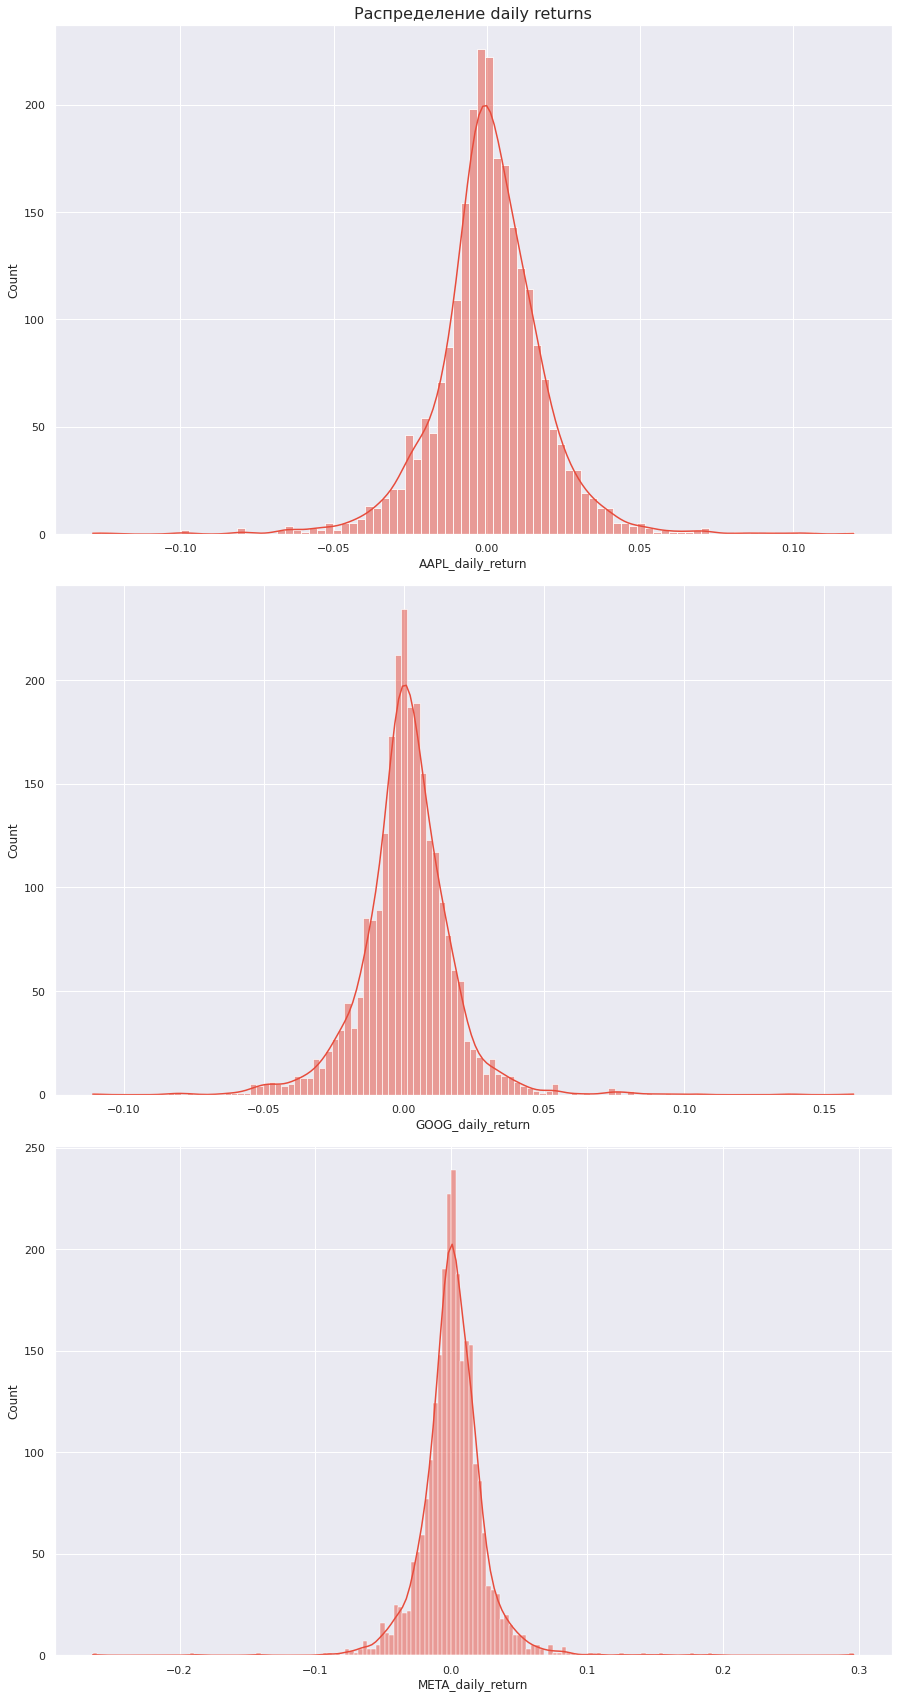

In [21]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 30))
plt.subplots_adjust(hspace=0.1)

histplot1 = sns.histplot(
    data= data, 
    x='AAPL_daily_return', 
    kde=True,
    #bins=30,
    ax=axes[0]
)
histplot1.set_title('Распределение daily returns', fontsize=16)

histplot2 = sns.histplot(
    data= data, 
    x='GOOG_daily_return',
    #bins=30,
    kde=True,
    ax=axes[1]
)

histplot3 = sns.histplot(
    data= data, 
    x='META_daily_return',
    #bins=30,
    kde=True,
    ax=axes[2]
)

По виду гистограмм можно предположить, что распределение носит характер нормального или t-распределения Стьюдента

In [22]:
# проверка на нормальность
H0 = 'имеет нормальное распределение'
Ha = 'НЕ имеет нормальное распределение'

alpha = 0.05

for col in daily_returns:
    _, p = normaltest(data[col])
    print('p=%.3f' % p)

    if p > alpha/2:
        print(col,H0)
    else:
        print(col,Ha)

p=0.000
AAPL_daily_return НЕ имеет нормальное распределение
p=0.000
GOOG_daily_return НЕ имеет нормальное распределение
p=0.000
META_daily_return НЕ имеет нормальное распределение


Значит мы имеем t-распределение Стьюдента, о чем также говорит характер хвостов распределения. Вычислим число степеней свободы.

In [23]:
for col in daily_returns:
    ticker = col.replace('_daily_return', '')
    print (f'Число степеней свободы для t-распределения dayly returns акции {ticker}: {round(stats.t.fit(data[col])[0],0)}')

Число степеней свободы для t-распределения dayly returns акции AAPL: 3.0
Число степеней свободы для t-распределения dayly returns акции GOOG: 3.0
Число степеней свободы для t-распределения dayly returns акции META: 3.0


array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>], dtype=object)

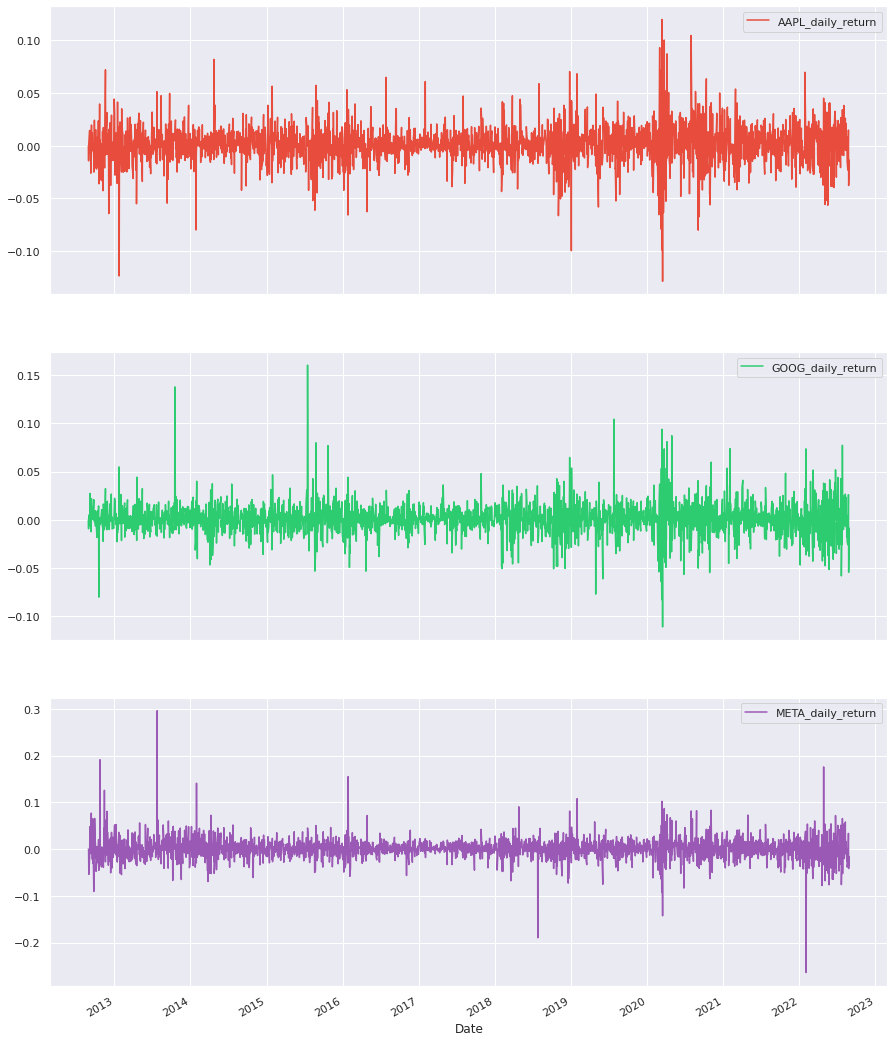

In [24]:
data[daily_returns].plot(subplots=True, figsize=(15,20))

По графикам можно предположить, что временные ряды стационраны, трендов, сезонностей не наблюдается 

Проверим стационраность рядов используя расширенный тест Дики – Фуллера

Нулевая гипотеза (H0): Временной ряд имеет единичный корень, то есть он нестационарный. Он имеет некоторую временную структуру.

Альтернативная гипотеза (H1): Нулевая гипотеза отвергается; Временной ряд не имеет единичного корня, то есть он является стационарным. 

In [25]:
alpha = 0.05
for col in daily_returns:
    result = adfuller(data[col])
    p = result[1]
    print('ADF Statistic: %.3f' % result[0])
    print('p-value: %.3f' % result[1])
    if p > alpha:
        print(f'Временной ряд {col}: не стационарен')
    else:
        print(f'Временной ряд {col}: является стационарным')
   

ADF Statistic: -16.208
p-value: 0.000
Временной ряд AAPL_daily_return: является стационарным
ADF Statistic: -12.659
p-value: 0.000
Временной ряд GOOG_daily_return: является стационарным
ADF Statistic: -15.539
p-value: 0.000
Временной ряд META_daily_return: является стационарным


In [26]:
#корелляция рядов
data[daily_returns].corr()

,AAPL_daily_return,GOOG_daily_return,META_daily_return
AAPL_daily_return,1.000000,0.550081,0.452512
GOOG_daily_return,0.550081,1.000000,0.559747
META_daily_return,0.452512,0.559747,1.000000


Для проверки связи между акциями Apple и Google выполним тест причинно-следственной связи по Грейнджеру

Нулевая гипотеза (H_0): временной ряд Apple не является временным рядом Google по причине Грейнджера.

Альтернативная гипотеза (H_A): временной ряд Apple временной ряд причин Грейнджера Google

In [27]:
grangercausalitytests(data[['AAPL_daily_return','GOOG_daily_return']], maxlag = 30)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.9992  , p=0.0144  , df_denom=2512, df_num=1
ssr based chi2 test:   chi2=6.0063  , p=0.0143  , df=1
likelihood ratio test: chi2=5.9992  , p=0.0143  , df=1
parameter F test:         F=5.9992  , p=0.0144  , df_denom=2512, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.0719  , p=0.0465  , df_denom=2509, df_num=2
ssr based chi2 test:   chi2=6.1560  , p=0.0461  , df=2
likelihood ratio test: chi2=6.1485  , p=0.0462  , df=2
parameter F test:         F=3.0719  , p=0.0465  , df_denom=2509, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.2075  , p=0.0852  , df_denom=2506, df_num=3
ssr based chi2 test:   chi2=6.6411  , p=0.0843  , df=3
likelihood ratio test: chi2=6.6324  , p=0.0846  , df=3
parameter F test:         F=2.2075  , p=0.0852  , df_denom=2506, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.8012  , p=0.

{1: ({'ssr_ftest': (5.999158708295594, 0.014380563410307643, 2512.0, 1),
   'ssr_chi2test': (6.006323308663781, 0.01425469909383982, 1),
   'lrtest': (5.999162556239753, 0.014312670670835428, 1),
   'params_ftest': (5.99915870829574, 0.014380563410305906, 2512.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (3.071885994941637, 0.04650799387692366, 2509.0, 2),
   'ssr_chi2test': (6.156015457380052, 0.046050911227571587, 2),
   'lrtest': (6.148490641338867, 0.04622449989625689, 2),
   'params_ftest': (3.0718859949414883, 0.04650799387692366, 2509.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.207539859764188, 0.08522822980533445, 2506.0, 3),
   'ssr_chi2test': (6.64111851666489, 0.08426022509570545, 3),
   'lrtest': (6.632358686692896, 0.08458623729916483, 3),
   'params_ftest': (2.2075398597642337, 0.0852282298053236, 2506.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0.,

Нулевая гипотеза отклоняется для всех значений лага по времени, кроме 3,4 и 5 дней. В остальном мы можем отвергнуть нулевую гипотезу, акции Apple влияют на акции Google

In [28]:
grangercausalitytests(data[['GOOG_daily_return','AAPL_daily_return']], maxlag=30)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.8181  , p=0.0508  , df_denom=2512, df_num=1
ssr based chi2 test:   chi2=3.8227  , p=0.0506  , df=1
likelihood ratio test: chi2=3.8198  , p=0.0507  , df=1
parameter F test:         F=3.8181  , p=0.0508  , df_denom=2512, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.8931  , p=0.1508  , df_denom=2509, df_num=2
ssr based chi2 test:   chi2=3.7937  , p=0.1500  , df=2
likelihood ratio test: chi2=3.7908  , p=0.1503  , df=2
parameter F test:         F=1.8931  , p=0.1508  , df_denom=2509, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4546  , p=0.2250  , df_denom=2506, df_num=3
ssr based chi2 test:   chi2=4.3759  , p=0.2236  , df=3
likelihood ratio test: chi2=4.3721  , p=0.2240  , df=3
parameter F test:         F=1.4546  , p=0.2250  , df_denom=2506, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.6366  , p=0.

{1: ({'ssr_ftest': (3.8181219052957807, 0.05081186212978875, 2512.0, 1),
   'ssr_chi2test': (3.822681764259112, 0.05056324858085645, 1),
   'lrtest': (3.8197795564119588, 0.05065090168926984, 1),
   'params_ftest': (3.81812190529581, 0.05081186212978875, 2512.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.8930568228435545, 0.15082577225903182, 2509.0, 2),
   'ssr_chi2test': (3.7936587107442774, 0.15004360076258869, 2),
   'lrtest': (3.7907992468499287, 0.15025827631975042, 2),
   'params_ftest': (1.8930568228433962, 0.1508257722590639, 2509.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.454581637985222, 0.22504593132218015, 2506.0, 3),
   'ssr_chi2test': (4.375934145558894, 0.22362725178241347, 3),
   'lrtest': (4.372128614486428, 0.22398366801189393, 3),
   'params_ftest': (1.4545816379852265, 0.22504593132218015, 2506.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0

При обратном рассмотрении мы принимаем нулевую гипотезу для значений maxlag в интервале от 8 до 15.

# 3

In [29]:
# Возьмем в работу акции Apple
#создаем 100 распределений предсказания f
f_list = []
for i in range (0,100):
     f_list.append(np.random.normal(0, 1, 2516))   

#считаем для каждого предсказания p&l
pnls = pd.DataFrame()
for i in range (0,100):
    col_name = 'pnl_'+str(i)
    pnls[i] = f_list[i]* data['AAPL_daily_return'].rename(col_name)

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>], dtype=object)

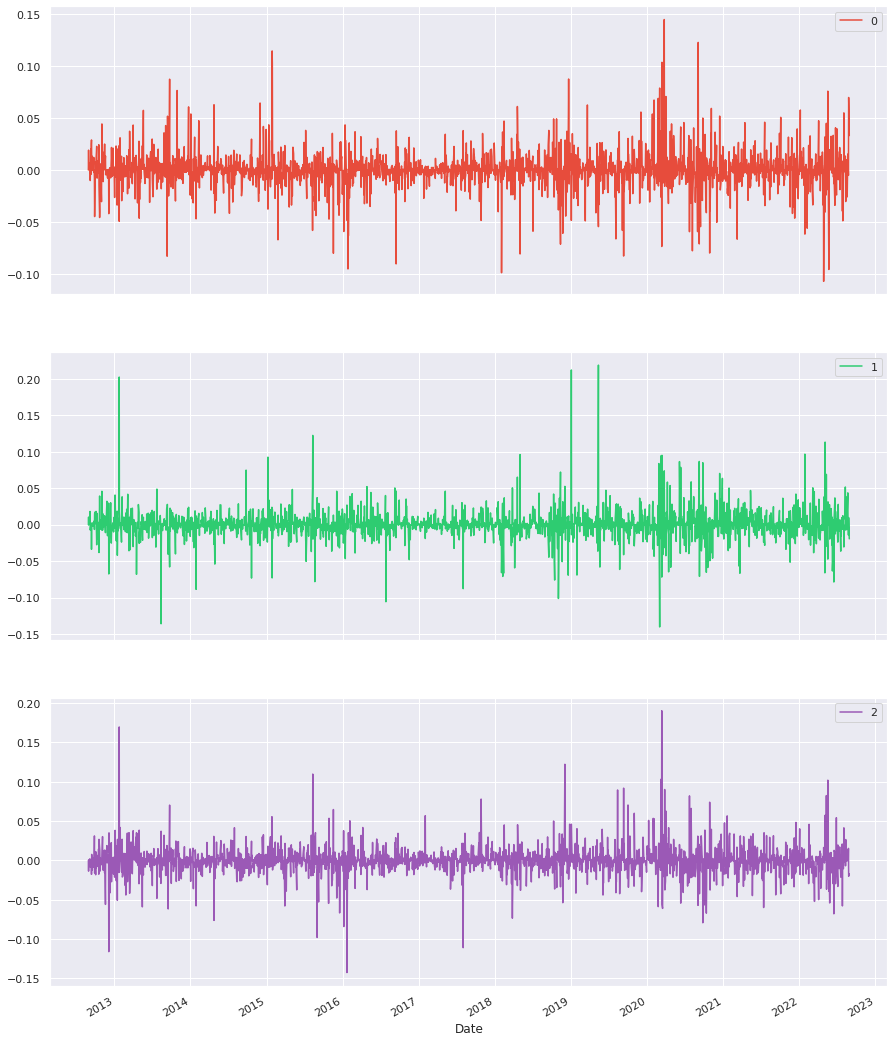

In [30]:
pnls[[0,1,2]].plot(subplots=True, figsize=(15,20))

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>], dtype=object)

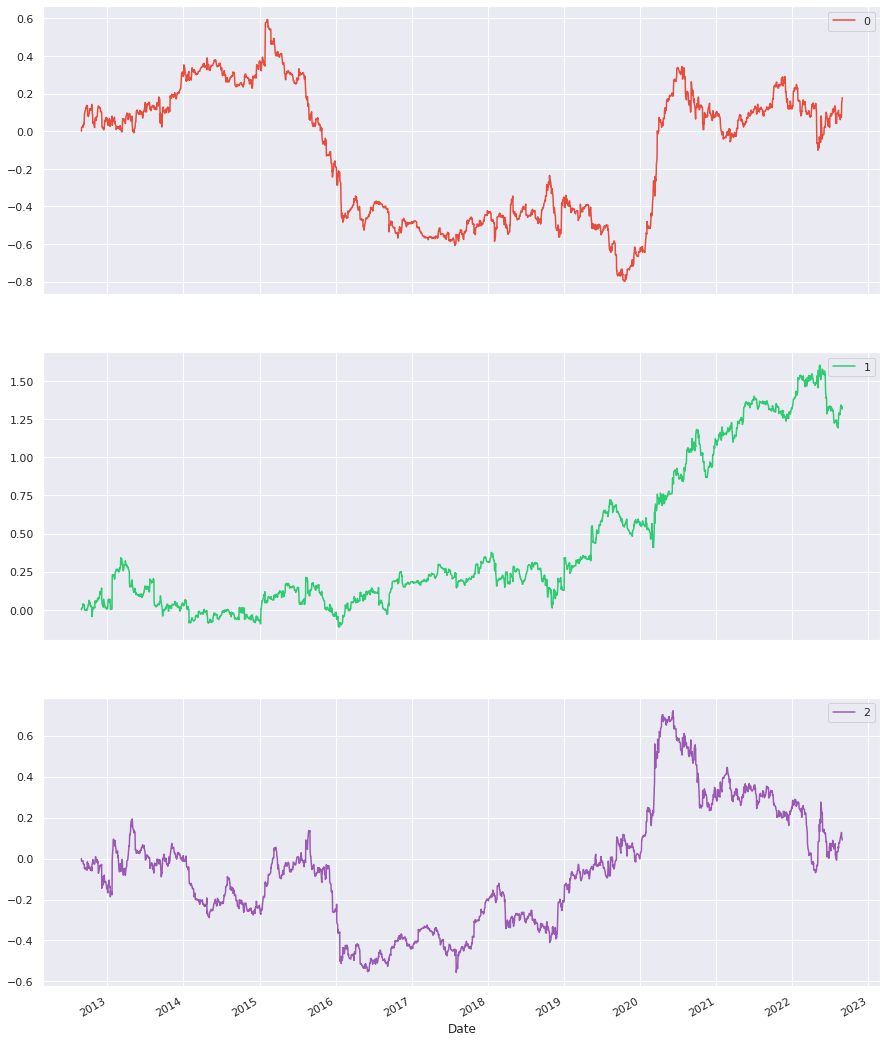

In [31]:
cumsum_pnls = pnls.cumsum()
cumsum_pnls[[0,1,2]].plot(subplots=True, figsize=(15,20))

Графики Profit-and-loss и коммулятивные Profit-and-loss отличаются критическим образом (выше на изображениях первые три точки из 100)

# 4

In [32]:
#создаем список коэффициент Шарпа
def sharpe_ratio_calc(returns, sample_size):
    return np.sqrt(sample_size) * (np.mean(returns)) / np.std(returns)

sharpe_ratio_list = []
for i in range (0,100):
    sharpe_ratio = sharpe_ratio_calc(pnls[i].values, pnls.shape[0])
    sharpe_ratio_list.append(sharpe_ratio)

In [33]:
#создаем список коэффициентов Hit Rate
hit_rate_list = []
for i in range (0,100):
    count = 0
    for j in range (0, data.shape[0]):
        if np.sign(data['AAPL_daily_return'][j]) == np.sign(f_list[i][j]):
            count += 1
        else:
            count += -1
    hit_rate = count / data.shape[0]
    hit_rate_list.append(hit_rate)

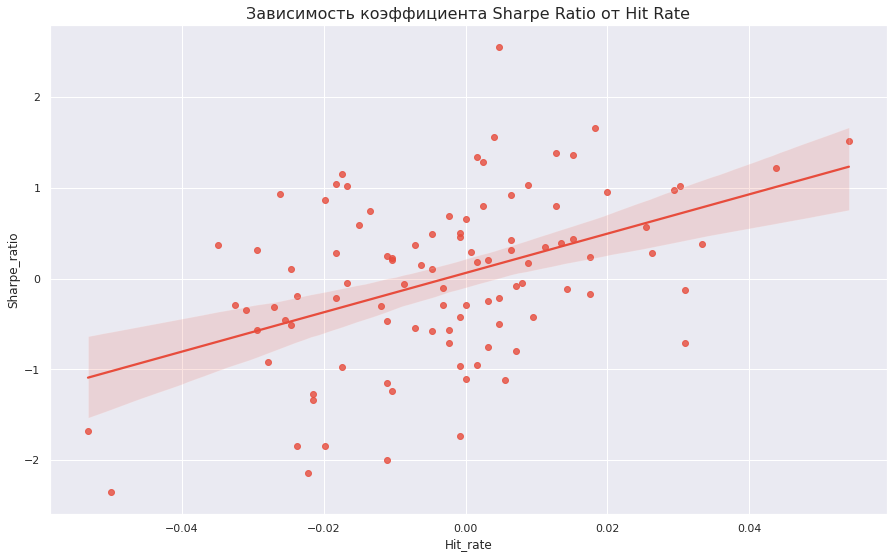

In [34]:
fig = plt.figure(figsize = (15, 9));
scatterplot = sns.regplot(x = hit_rate_list, y = sharpe_ratio_list)
scatterplot.set_ylabel('Sharpe_ratio');
scatterplot.set_title('Зависимость коэффициента Sharpe Ratio от Hit Rate', fontsize = 16);
scatterplot.set_xlabel('Hit_rate');
plt.show() 

Коэффициент Шарпа растет с увеличением точности предсказания

# 5

In [35]:
# загружаем данные
url='https://drive.google.com/file/d/1B6fA8FAz874hl2vdpkGPND0IU9gd0AAO/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(url)
df.head()

,a,b,c,d,class
0,-0.233408,-0.845698,0.365256,0.311292,1.0
1,0.073524,-0.747284,0.586381,0.303840,1.0
2,0.105561,-0.749805,0.149815,0.635771,1.0
3,-0.642419,-0.342424,-0.608454,0.229135,0.0
4,0.296581,-0.656553,0.022429,0.639708,0.0


In [36]:
# неразмеченная часть данных
X_test = df[df['class'].isna()].drop(['class'], axis=1)

In [37]:
#разбиваем размеченные данные на обучающую и валидационную выборку
df = df.dropna(how='any', axis=0)

X = df.drop(['class'], axis=1)
y = df['class']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.2)

In [38]:
# пробуем модель логистической регрессии
log_reg = linear_model.LogisticRegression(max_iter=1000)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)

y_test_pred = log_reg.predict(X_valid)
print(metrics.classification_report(y_valid, y_test_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       209
         1.0       0.66      1.00      0.80       406

    accuracy                           0.66       615
   macro avg       0.33      0.50      0.40       615
weighted avg       0.44      0.66      0.53       615



Модель не отработала по классу "0"

In [39]:
# пробуем модель случайного леса с параметрами по умолчанию
rf = ensemble.RandomForestClassifier(random_state=42)

#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики 

y_valid_pred = rf.predict(X_valid)
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

         0.0       0.46      0.27      0.34       209
         1.0       0.69      0.84      0.76       406

    accuracy                           0.65       615
   macro avg       0.58      0.56      0.55       615
weighted avg       0.61      0.65      0.62       615



Результат лучше, попробуем подобрать гиперпараметры

In [40]:
def optuna_rf(trial):
    # задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators',  100, 300, 10)
    max_depth = trial.suggest_int('max_depth', 15, 26, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
    criterion = trial.suggest_categorical('criterion', ['entropy','gini'])

    # создаем модель
    model = RandomForestClassifier(n_estimators = n_estimators,
                                          max_depth = max_depth,
                                          min_samples_leaf = min_samples_leaf,
                                          criterion = criterion,
                                          random_state = 42)
    # обучаем модель
    model.fit(X_train, y_train)
    score = metrics.accuracy_score(y_valid, model.predict(X_valid))

    return score

In [41]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=50)
print("Наилучшие значения гиперпараметров {}".format(study.best_params))

[I 2022-09-02 22:27:01,508] A new study created in memory with name: RandomForestClassifier
[I 2022-09-02 22:27:02,867] Trial 0 finished with value: 0.6585365853658537 and parameters: {'n_estimators': 240, 'max_depth': 18, 'min_samples_leaf': 8, 'criterion': 'entropy'}. Best is trial 0 with value: 0.6585365853658537.
[I 2022-09-02 22:27:04,468] Trial 1 finished with value: 0.6455284552845528 and parameters: {'n_estimators': 270, 'max_depth': 26, 'min_samples_leaf': 5, 'criterion': 'entropy'}. Best is trial 0 with value: 0.6585365853658537.
[I 2022-09-02 22:27:05,383] Trial 2 finished with value: 0.6455284552845528 and parameters: {'n_estimators': 220, 'max_depth': 18, 'min_samples_leaf': 5, 'criterion': 'gini'}. Best is trial 0 with value: 0.6585365853658537.
[I 2022-09-02 22:27:06,739] Trial 3 finished with value: 0.6390243902439025 and parameters: {'n_estimators': 240, 'max_depth': 25, 'min_samples_leaf': 6, 'criterion': 'entropy'}. Best is trial 0 with value: 0.6585365853658537.
[I 

Наилучшие значения гиперпараметров {'n_estimators': 260, 'max_depth': 24, 'min_samples_leaf': 9, 'criterion': 'entropy'}
CPU times: user 1min 13s, sys: 126 ms, total: 1min 13s
Wall time: 1min 13s


In [42]:
model_rf = ensemble.RandomForestClassifier(**study.best_params,random_state=42)

model_rf.fit(X_train, y_train)

y_valid_pred = model_rf.predict(X_valid)
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

         0.0       0.50      0.12      0.19       209
         1.0       0.67      0.94      0.78       406

    accuracy                           0.66       615
   macro avg       0.59      0.53      0.49       615
weighted avg       0.62      0.66      0.58       615



Результаты на классе "0" по прежнему слабые, попробуем градиентный бустинг

In [43]:
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_valid)
print(metrics.classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

         0.0       0.54      0.03      0.06       209
         1.0       0.66      0.99      0.79       406

    accuracy                           0.66       615
   macro avg       0.60      0.51      0.43       615
weighted avg       0.62      0.66      0.55       615



In [44]:
def optuna_gb(trial):
    # задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators',  100, 300, 10)
    max_depth = trial.suggest_int('max_depth', 15, 26, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    # создаем модель
    model = ensemble.GradientBoostingClassifier(n_estimators = n_estimators,
                                          max_depth = max_depth,
                                          min_samples_leaf = min_samples_leaf,
                                          random_state = 42)
    # обучаем модель
    model.fit(X_train, y_train)
    score = metrics.accuracy_score(y_valid, model.predict(X_valid))

    return score

In [45]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="GradientBoostingClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_gb, n_trials=50)
print("Наилучшие значения гиперпараметров {}".format(study.best_params))

[I 2022-09-02 22:28:17,722] A new study created in memory with name: GradientBoostingClassifier
[I 2022-09-02 22:28:22,961] Trial 0 finished with value: 0.5983739837398374 and parameters: {'n_estimators': 270, 'max_depth': 23, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.5983739837398374.
[I 2022-09-02 22:28:27,675] Trial 1 finished with value: 0.6032520325203252 and parameters: {'n_estimators': 280, 'max_depth': 17, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.6032520325203252.
[I 2022-09-02 22:28:30,212] Trial 2 finished with value: 0.6113821138211382 and parameters: {'n_estimators': 110, 'max_depth': 18, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.6113821138211382.
[I 2022-09-02 22:28:33,571] Trial 3 finished with value: 0.6130081300813008 and parameters: {'n_estimators': 150, 'max_depth': 25, 'min_samples_leaf': 8}. Best is trial 3 with value: 0.6130081300813008.
[I 2022-09-02 22:28:36,527] Trial 4 finished with value: 0.6130081300813008 and parameters:

Наилучшие значения гиперпараметров {'n_estimators': 260, 'max_depth': 19, 'min_samples_leaf': 3}
CPU times: user 3min 33s, sys: 35.2 ms, total: 3min 33s
Wall time: 3min 33s


In [46]:
gb_model = GradientBoostingClassifier(**study.best_params,random_state=42)

gb_model.fit(X_train, y_train)


y_valid_pred = gb_model.predict(X_valid)
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

         0.0       0.43      0.30      0.35       209
         1.0       0.69      0.80      0.74       406

    accuracy                           0.63       615
   macro avg       0.56      0.55      0.55       615
weighted avg       0.60      0.63      0.61       615



На этом сегодня остановимся, подготовим предсказание для неразмеченных данных. 

In [47]:
y_test_predict = gb_model.predict(X_test)

In [48]:
result = pd.DataFrame({'class': y_test_predict})
result.to_csv('result.csv', index=False)
result.head()

,class
0,1.0
1,1.0
2,0.0
3,1.0
4,1.0
